# Bee ML
This notebook shows a simple model able to improve the daily life of of many beekeepers.

- **DATA:** all data are downloaded from Kaggle (https://www.kaggle.com/se18m502/bee-hive-metrics). In this project I use the data of humity, temperature and weight of the years 2017-2019 of two hives (from Wurzburg and Schwartau).

- **AIM:** The aim of the project is to develop an algorithm able to predict the amount of honey produced by bee in a place in a week. 

- **EVERY DAY LIFE:** For each week we will need the weather forecast for the next week. In the every day life, the beekeeper should use this model to understand which is the best place to leave the hives for the next week. The output of the model is percentage amount of growth of honey in the next week given the weather forecast.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Read data (https://www.kaggle.com/se18m502/bee-hive-metrics))
humidity_w = pd.read_csv("bee-hive-metrics/humidity_wurzburg.csv")
humidity_s = pd.read_csv("bee-hive-metrics/humidity_schwartau.csv")
temperature_w = pd.read_csv("bee-hive-metrics/temperature_wurzburg.csv")
temperature_s = pd.read_csv("bee-hive-metrics/temperature_schwartau.csv")
weight_w = pd.read_csv("bee-hive-metrics/weight_wurzburg.csv")
weight_s = pd.read_csv("bee-hive-metrics/weight_schwartau.csv")

## Preprocessing 

In [3]:
# This function trasforms the input data taking the min, max, and mean for each day 
def transform_df(df,col):
    """
    This function transfom the data calculating the min, max and mean for 
    each day
    Args:
        df: dataframe to transform
        col: column to group
    Return:
        Transformed dataframe with min, max and mean of col
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S")
    df['day'] = df['timestamp'].apply(lambda x: x.day)
    df['month'] = df['timestamp'].apply(lambda x: x.month)
    df['year'] = df['timestamp'].apply(lambda x: x.year)    
    df = df.groupby(['year','month','day']).agg({col:['min','max','mean']}).reset_index()
    df.columns = df.columns.map('_'.join)
    return df

In [4]:
# Transfom all the dataframs
hum_w = transform_df(humidity_w,'humidity')
hum_s = transform_df(humidity_s,'humidity')
tem_w = transform_df(temperature_w,'temperature')
tem_s = transform_df(temperature_s,'temperature')
wei_w = transform_df(weight_w,'weight')
wei_s = transform_df(weight_s,'weight')

In [5]:
# Merge all the data
w_data = (hum_w
          .merge(tem_w, on=['year_','month_','day_'])
          .merge(wei_w, on=['year_','month_','day_'])
          )
s_data = (hum_s
          .merge(tem_s, on=['year_','month_','day_'])
          .merge(wei_s, on=['year_','month_','day_'])
          )
all_data = pd.concat([w_data,s_data]).reset_index(drop=True)

In [6]:
"""
Here I create the dataset for training. The dataset takes 7 days of weather 
information (humidity and temperature) added to columns with months of the data.  
"""
len_window = 7
X =[]
y = []
for i in range(len(all_data)):
    row_i = [all_data.loc[i,'month_']]
    weight_i = all_data.loc[i,'weight_mean']
    if i+len_window>len(all_data): break
    for j in range(len_window):
        row_i= row_i+[all_data.loc[i+j,'humidity_min'],
                             all_data.loc[i+j,'humidity_max'],
                             all_data.loc[i+j,'humidity_mean'],
                             all_data.loc[i+j,'temperature_min'],
                             all_data.loc[i+j,'temperature_max'],
                             all_data.loc[i+j,'temperature_mean']]
        if j == (len_window-1):
            weight_f = all_data.loc[i+j,'weight_mean']
            delta_weight = ((weight_f-weight_i)/weight_i)*100
            if delta_weight>100: delta_weight=100.
            if delta_weight<-100: delta_weight=-100.    
            y.append(delta_weight)
            X.append(row_i)
data_model_full = pd.DataFrame(X)
data_model_full['y'] = pd.Series(y)

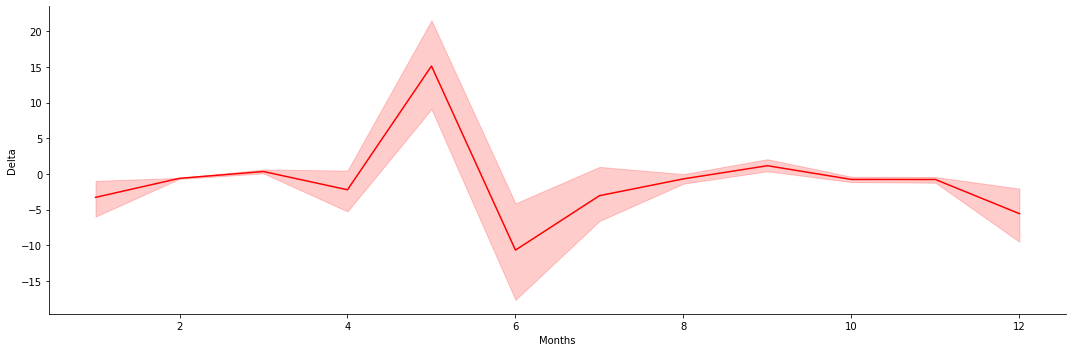

In [7]:
# Plotting target
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.relplot(x=0, y="y", data=data_model_full,height=5,kind="line",aspect=3,color='red')
ax.set(xlabel='Months', ylabel='Delta')
plt.savefig("target.png",dpi=300)
plt.show()

In [8]:
# Drop null values
data_model_full = data_model_full.dropna()

In [9]:
col_name = ["month"]
for day in range(7):
    col_name.append("Hmin_"+str(day))
    col_name.append("Hmax_"+str(day))
    col_name.append("Hmean_"+str(day))
    col_name.append("Tmin_"+str(day))
    col_name.append("Tmax_"+str(day))
    col_name.append("Tmean_"+str(day))
col_name.append("delta_w")    
data_model_full.columns = col_name
data_model_full.head()

,month,Hmin_0,Hmax_0,Hmean_0,Tmin_0,Tmax_0,Tmean_0,Hmin_1,Hmax_1,Hmean_1,...,Tmin_5,Tmax_5,Tmean_5,Hmin_6,Hmax_6,Hmean_6,Tmin_6,Tmax_6,Tmean_6,delta_w
0,1,90.945000,93.768333,92.058947,-5.1744,6.050467,-0.082160,92.130000,93.533333,92.794722,...,-8.7460,18.896000,-0.937771,81.615000,93.590000,89.077361,-10.0720,9.365183,-2.648782,-0.525869
1,1,92.130000,93.533333,92.794722,-2.4640,8.452600,1.825578,87.871667,92.716667,91.173472,...,-10.0720,9.365183,-2.648782,89.520000,90.816667,90.131181,-3.8698,7.731600,1.812449,-0.040630
2,1,87.871667,92.716667,91.173472,-0.5704,10.064000,3.082557,88.841667,93.055000,91.077917,...,-3.8698,7.731600,1.812449,89.081667,90.948333,90.166528,0.6620,9.885500,3.659525,-0.067327
3,1,88.841667,93.055000,91.077917,-0.6370,9.798667,3.750071,75.839333,89.576667,82.656076,...,0.6620,9.885500,3.659525,82.250000,89.778333,86.372014,-1.4738,13.534500,4.034587,-0.068585
4,1,75.839333,89.576667,82.656076,-4.6214,9.566917,2.259225,87.911667,93.686667,91.545347,...,-1.4738,13.534500,4.034587,84.926667,91.686667,87.873681,-0.1502,11.806167,4.752350,-0.281404


In [10]:
# Division in features and target
X = data_model_full.drop('delta_w',axis=1)
y = data_model_full['delta_w']

In [11]:
# Standard scalar for features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [12]:
# Libraries for different models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [13]:
# Divide in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [14]:
# Function for train the model and optimize the parameters
def train_model(model,param,n_cv,X,y):
    """
    This function train the model
    Args:
        model: sklearn model
        param: dictionary with parameters for the Grid Search
        n_cv: number of folds for the cross validation
        X: features
        y: target
    Return:
        Trained model
    """
    gs = GridSearchCV(model, param,cv=n_cv,n_jobs=-1)
    gs.fit(X,y)
    return gs

In [15]:
from sklearn.metrics import mean_squared_error
def evaluate_regressor(model,y_true,y_pred):
    """
    This function evaluates the regressor with the root mean square error
    Args:
        model: sklearn model to evaluate
        y_true: true data
        y_pred: predicted data
    Return:
        Root mean square error
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse     

## Modelling

In [16]:
# Gradient Boosting
gbr = GradientBoostingRegressor()
parameters_gb ={"learning_rate":[0.1],
                "n_estimators":[30],
                "min_samples_split":[2,4,8],
                "min_samples_leaf":[1,5],
                "max_depth":[3,5,10]
               }
model = train_model(gbr,parameters_gb,5,X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
rmse_train = evaluate_regressor(model,y_train,y_pred_train)
rmse_test = evaluate_regressor(model,y_test,y_pred_test)
print(rmse_train,rmse_test)

5.889004061231692 19.427948574937066


In [17]:
# Linear model
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters_ridge={"alpha":[1.0,1.2,0.5],
               }
model = train_model(ridge,parameters_ridge,5,X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
rmse_train = evaluate_regressor(model,y_train,y_pred_train)
rmse_test = evaluate_regressor(model,y_test,y_pred_test)
print(rmse_train,rmse_test)

18.74510801988328 22.397383257269844


In [18]:
# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
pol = PolynomialFeatures(degree=2)
X_train_p = pol.fit_transform(X_train)
X_test_p = pol.fit_transform(X_test)
lm = LinearRegression()
parameters_lm={}
model = train_model(lm,parameters_lm,2,X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
rmse_train = evaluate_regressor(model,y_train,y_pred_train)
rmse_test = evaluate_regressor(model,y_test,y_pred_test)
print(rmse_train,rmse_test)

18.738081793640532 23.52098172104173


In [19]:
# Random Forest
rfr = RandomForestRegressor()
parameters_rfr ={"n_estimators":[100],
                "min_samples_split":[2,4,8],
                "min_samples_leaf":[1,5],
                "max_depth":[None,3,5],
                 "max_features":["auto","sqrt",4,2],
                 "random_state":[1029]
               }
model = train_model(rfr,parameters_rfr,3,X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
rmse_train = evaluate_regressor(model,y_train,y_pred_train)
rmse_test = evaluate_regressor(model,y_test,y_pred_test)
print(rmse_train,rmse_test)

6.635852665779878 18.017573710807845


<Figure size 1440x288 with 0 Axes>

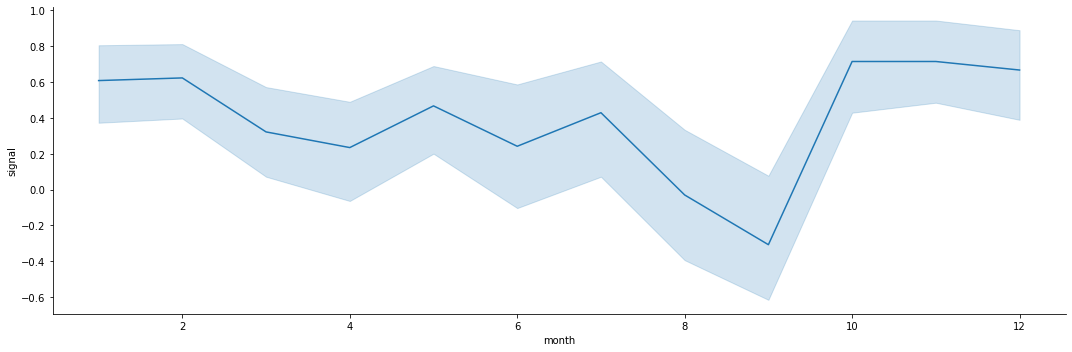

In [20]:
"""
The graph shows the concordance between the prevision of increase or
decrease of honey of the model  and the real values. When both model and real
data show an increase of honey in the next week the values is
equal to 1. Instead when there is a divergence about the prevision 
and the reality the values are equal to -1.
"""
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_test_series = pd.Series(y_pred_test)
y_test_series = y_test.reset_index(drop=True)
month = pd.Series(sc.inverse_transform(X_test)[:,0])
df_predicted = pd.DataFrame()
df_predicted["true"] = y_test_series
df_predicted["predicted"] = y_pred_test
df_predicted["month"] = month
df_predicted["signal"] =  y_test_series*y_pred_test/abs(y_test_series*y_pred_test)
df_predicted = df_predicted.sort_values(by=["month"]).reset_index(drop=True)
plt.figure(figsize=(20,4))
sns.relplot(x='month', y='signal',
            data=df_predicted,
            kind="line",
            height=5,
            aspect=3)
ax.set(xlabel='Months', ylabel='Concordace')
plt.savefig("concordance.png",dpi=300)

## Conclusion
From testing different models, the random forest regression tourned out the best model with an $RMSE=18.2$. The graph shows an high accuracy from October to July, while a bad accuray in August and September. I believe this fact is due to the human intervention done in the hives during this period.